In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder

# Entendimento do negócio

O _dataset_ utilizado ([doi.org/10.24432/C5R88H](https://doi.org/10.24432/C5R88H)) envolve a expressão de genes para diferentes tipos de cancer, em diferentes pacientes.

O _dataset_ oferece rótulos, e cada item é classificado. Porém, para fins didáticos, será usado uma versão sem rótulos.
Desta forma, o objetivo é agrupar estes pacientes de forma que cada tipo de cancer forme um grupo.

In [5]:
url = 'https://github.com/JCFDGG/LOB1266-PUB/raw/refs/heads/main/ExemplosAula/cluster/TCGA-PANCAN/data.csv'
caminho = 'dados/data.csv'

# Entendimento dos dados
Um simples `.info()` nos permite ver que não há necessidade de manipulação de dtypes.

In [6]:
df = pd.read_csv(caminho, index_col= 0) # Carrega a DataFrame
df.info() # Retorna as informações bases

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, sample_0 to sample_800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5+ MB


Há apenas dados numéricos.

In [7]:
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Facilmente, também é possível ver que não há nenhum `NaN`:

In [8]:
df.isna().any().any()
# df.isna() Retorna a DataFrame com True para itens que são NaN
# .any() # Retorna uma lista de colunas com True
# .any() # Retorna se tem ao menos um item com coluna True

False

# Preparação dos dados


## Scaling

O modelo *Kmeans* funciona no conceito de distância. Desta forma, valores mais altos podem atrapalhar a performance do modelo. Como não sabemos se quais atributos são mais importantes, é comum padronizar todos.

A principal forma é através de [scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html):

Em diante será usado o `StandardScaler()`, porém, é possível usar [outros](https://scikit-learn.org/stable/api/sklearn.preprocessing.html#module-sklearn.preprocessing), já que cada um lida com *outliers* de maneiras [diferentes](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

# Modelagem E analise


## Modelagem
O uso modelo [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) é como todos os outros modelos. A principal diferença é que não é necessário rótulos ou uma *ground truth*, desta forma, uma pipeline pode ser feita e aplicada sem a necessidade de *train/test split*.

In [12]:
from sklearn.cluster import KMeans

O principal parâmetro a ser modificado no *KMeans* é o `n_clusters=int`, que define a quantidade de clusters (grupos) que serão feitos:

In [13]:
model = KMeans(n_clusters=5) # Cria o modelo KMeans com 5 clusters

In [14]:
pipe = Pipeline([('scaler', scaler),
                 ('kmeans', model)])

In [15]:
pipe.fit(df) # Treina o modelo

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=5))])

## Resultados
As classificações podem ser acessadas por diferentes métodos.



Pelo atributo `.labels_` do modelo:

In [16]:
labels = pipe['kmeans'].labels_
labels[0:5] # Retorna as 5 primeiras classificações

array([1, 4, 1, 1, 3], dtype=int32)

Pode ser também adquirido ao usar do `.predict()` nos dados originais, ou em dados novos.

In [17]:
labels = pipe.predict(df)
labels[0:5] # Retorna os cinco primeiros itens

array([1, 4, 1, 1, 3], dtype=int32)

Também pode ser atribuído a uma variável junto com o treino do modelo, através do método fit_predict.



In [21]:
labels = pipe.fit_predict(df)
labels[0:5] # Retorna os cinco primeiros itens

array([4, 3, 4, 4, 0], dtype=int32)

## Análise
O principal problema da análise de um modelo não-supervisionado é o desenvolvimento de um método de pontuação: como saber se uma predição foi a "correta" sem uma comparação com uma verdade.

Felizmente, há diversas métricas oferecidas pelo `sklearn.metrics` que permitem a avaliação do modelo.

### Com labels
Como sabemos, neste caso, a classificação original, podemos usar de diversos métodos de comparação:

In [18]:
# Cria a DataFrame com os rótulos oficiais
df_labels = pd.read_csv('https://github.com/JCFDGG/LOB1266-PUB/raw/refs/heads/main/ExemplosAula/cluster/TCGA-PANCAN/labels.csv')

# Seleciona a coluna Class
true_labels = df_labels['Class']
true_labels[0:5] # Retorna os cinco primeiros itens

0    PRAD
1    LUAD
2    PRAD
3    PRAD
4    BRCA
Name: Class, dtype: object

A explicação dos métodos podem ser melhor exploradas na [documentação](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

In [19]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, pair_confusion_matrix

### Scores
Há diversos diferentes tipos de , e seus usos dependem da necessidade. Porém, todos se baseiam em semelhança, isto é, se os membros foram agrupados no mesmo grupo.

O método [`pair_confusion_matrix()`](https://scikit-learn.org/stable/modules/clustering.html#pair-confusion-matrix) retorna uma matriz com números de pares (e permutações) comparados com os grupos originais.

$$
\begin{split}C = \left[\begin{matrix}
C_{00} & C_{01} \\
C_{10} & C_{11}
\end{matrix}\right]\end{split}
$$
$C_{00}$ é o número de pares que não estavam no mesmo grupo, e o modelo corretamente colocou em grupos diferentes;  
$C_{11}$ é o número de pares que estavam no mesmo grupo, e o modelo corretamente colocou no mesmo grupo.  
$C_{01}$ é o número de pares que estavam em grupos diferentes, mas o modelo colocou no mesmo grupos.  
$C_{10}$ é o número de pares que estavam no mesmo grupo, mas o modelo colocou em grupos diferentes.

Uma classificação perfeita seria
$$
\begin{split}C = \left[\begin{matrix}
C_{00} & 0 \\
0 & C_{11}
\end{matrix}\right]\end{split}
$$

In [20]:
pair_confusion_matrix(true_labels, labels)

array([[467282,  18542],
       [ 28158, 126818]])

O `rand_score()` retorna o valor de pares em que os rótulos "concordam" $(\frac{C_{00} + C_{11}}{C_{00} + C_{11} + C_{10} + c_{01}})$.  Ela é baseado no Rand Index:
$$
RI = \frac{\text{Agrupagens corretas}}{\text{Número total de pares}}
$$

Já o `adjusted_rand_score()` ajusta o resultado para considerar rotulagem aleatória. Desta forma, uma rotulagem aleatória resulta em 0, e uma rotulagem perfeita em 1.
Em que as agrupagens corretas são dadas pela soma de pares que foram corretamente agrupados juntos ou separados.  
$$
ARI = \frac{\text{RI} - \text{RI}_{\text{esperado}} }{\text{RI}_{\text{Máximo}} - \text{RI}_{\text{esperado}} }
$$
Em que $RI_{\text{esperado}}$ é o valor médio de RI quando a agrupagem ocorre aleatoriamente.

In [21]:
adjusted_rand_score(true_labels, labels)

0.7969795067048849

Há outras [métricas de interesse](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics.cluster),  alguns são baseados em uma _ground truth_, enquanto outros em outros métodos. Mas a impĺementação tende a ser semelhante. Segue um exemplo de `normalized_mutual_info_score()`:

In [22]:
from sklearn.metrics import normalized_mutual_info_score
normalized_mutual_info_score(true_labels, labels)

0.8577921445029066

## Sem labels

Quando não se sabem os grupos corretos, há diferentes métodos de avaliar o modelo.  
O valor mais simples é a `inertia_`, que é a soma das distâncias entre os membros de um grupo e seu centróide. Este valor já é incorporado ao modelo após aplicar `.fit()`

In [25]:
pipe['kmeans'].inertia_

12197185.766132312

O problema deste valor é que, em espaços de altas dimensões (como as 20 mil que temos), o valor se torna extremo.  
Assim, é necessário um valor que permite alterar a métrica usada para o cálculo das distâncias, como `silhouette_score()`:

In [26]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

O argumento `metric='euclidian'` permite alterar a fórmula de distância utilizada. Caso omitido, o valor padrão é `'euclidian'`. Um valor próximo de 1 indica grupos densos e com baixa sobreposição.

In [27]:
print(""" Silhouette_score para: \n
metric=euclidian : %.3f
metric=cosine : %.3f""" % (
    silhouette_score(df, labels, metric='euclidean'), # O silhouette_score com métrica euclidean
    silhouette_score(df, labels, metric='cosine') # O silhouette_score com métrica cosine
    )
)

 Silhouette_score para: 

metric=euclidian : 0.209
metric=cosine : 0.352


Também existe o `Davies_bouldin_score`, que é melhor para dados convexos e de diferentes tamanhos. Quanto mais próximo de 0, melhor o modelo.

In [28]:
davies_bouldin_score(df,labels)

2.0763990390999267

Novamente, estes valores indicam um modelo ruim, porém, como há >20 mil dimensões, é ideal reduzi-las para obter um resultado mais coerente.

## Redução de Dimensão

## Principal Component Analysis
Visto que um dos maiores problemas surge por causa do excesso de dimensões. Assim, é necessário métodos de reduzir essas dimensões, mas retendo as relações entre os pontos.  
Há diversos métodos que permitem atingir este objetivo. Aqui, introduz-se o `Principal Component Analysis`, ou PCA, que pode ser usado tanto no treinamento do modelo, como na avaliação.

In [29]:
from sklearn.decomposition import PCA # Importar PCA

Vamos copiar para uma `df_copia`, para evitar alterar a DataFrame original:

In [34]:
df_copia = df.copy()

O uso de PCA segue a mesma lógica de outros modelos, por esse motivo, vamos criar uma pipeline. O principal argumento do PCA é o `n_components`, que determina o número de dimensões finais.

In [40]:
pca_5_componentes = PCA(n_components=5, # Reduzir pelo método PCA em 5 dimensões
          random_state=123) # Utilizar de random_state para reprodutibilidade

pipe_pca_5_componentes = Pipeline([('standard_scaler', scaler), # Scaler para auxiliar
                 ('pca', pca_5_componentes)])

df_pca_5_componentes = pd.DataFrame(pipe_pca_5_componentes.fit_transform(df_copia)) # Salva a DataFrame transformada

df_pca_5_componentes.head()

,0,1,2,3,4
0,-57.446987,-95.410981,74.301543,12.166782,-7.981816
1,-16.919430,-0.732470,-64.072900,2.095309,25.426441
2,-70.345218,19.303327,20.488241,-48.102894,-24.437771
3,-49.161591,9.227586,61.243770,-37.805744,-1.038912
4,-18.132534,51.327797,16.598116,17.699203,-26.389116


Caso $ 0 < {n\_components} < 1 $, o modelo automaticamente calcula o número de dimensões necessárias para explicar `n_components` da variância.
Por exemplo, para explicar 80% da variância dos dados:

In [39]:
pca_80_varianca = PCA(n_components=0.8, # Reduzir pelo método PCA até ter 90% das variâncias
                      random_state=123) # Utilizar de random_state para reprodutibilidade

pipe_pca_80_varianca = Pipeline([('standard_scaler', scaler), # Scaler para auxiliar
                                 ('pca', pca_80_varianca)])

df_pca_80_varianca = pd.DataFrame(pipe_pca_80_varianca.fit_transform(df_copia)) # Salva a DataFrame transformada

df_pca_80_varianca.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,-57.446987,-95.410981,74.301543,12.166781,-7.981831,-36.157573,-7.668542,19.951444,0.142216,-3.035240,...,-3.494319,-3.425565,-3.554186,-2.602252,-5.895638,-0.907671,9.060001,-3.528184,3.221192,4.024332
1,-16.919430,-0.732470,-64.072900,2.095308,25.426430,-27.784178,-16.132765,-17.031383,-22.023874,27.923308,...,-4.523526,5.590659,-2.262219,1.414662,1.282629,2.892098,0.280350,-3.223604,-2.275011,-0.251812
2,-70.345218,19.303327,20.488240,-48.102893,-24.437757,-17.462510,20.706772,-47.626817,-28.647648,12.784676,...,-5.868215,-2.636948,6.090371,4.090740,-10.278097,-8.018019,1.712496,-10.784348,11.152698,-2.664590
3,-49.161591,9.227586,61.243770,-37.805744,-1.038889,-23.240002,-4.801039,-21.554809,-15.375067,12.881511,...,0.660787,-1.121139,-0.081250,1.166404,-0.886662,-0.025059,5.830756,-1.113062,0.430741,0.092854
4,-18.132534,51.327797,16.598116,17.699201,-26.389130,1.551573,-6.266101,12.336677,-4.233837,-28.804476,...,-0.375315,1.854333,-0.322975,-1.235294,-6.195407,-2.392793,-3.220275,-5.038342,0.691079,-4.201646


Logo, é necessário o seguinte número de variáveis para esplicar 80% da variância:

In [41]:
len(df_pca_80_varianca.columns)

183

O `PCA()` também permite retornar ao espaço original (ou criar um novo para dados no espaço reduzido) através do `.inverse_transform()`

In [42]:
df_invertida = pipe_pca_80_varianca.inverse_transform(df_pca_80_varianca) # Retorna ao espaço original
df_refeita = pd.DataFrame(df_invertida) # Transforma em dataframe
df_refeita.head()

,0,1,2,3,4,5,6,7,8,9,...,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530
0,0.097959,1.708975,3.421912,5.853820,10.317558,-8.659284e-15,7.594585,0.426568,0.014766,0.139794,...,4.820803,7.963971,9.589828,6.482212,9.272856,11.968327,9.671142,8.974697,5.519343,-0.270373
1,0.056733,0.788220,2.051626,7.345002,9.610500,4.895818e-15,7.271408,-0.223188,-0.081279,-0.112710,...,5.176499,7.899945,9.792975,5.351498,9.071337,12.483401,10.173814,9.387638,4.634475,-0.006584
2,0.029048,3.136428,3.991829,7.163380,9.673460,2.913141e-15,7.528437,0.559574,0.118249,-0.024579,...,5.108840,8.173096,10.849413,4.983121,9.721072,9.393784,9.528904,9.907207,1.807970,0.218044
3,0.003667,3.734951,4.285568,6.832610,10.309549,-2.515353e-15,7.860082,0.308389,0.076466,-0.008695,...,6.133624,8.966699,10.095806,8.322338,9.562054,11.106875,9.948159,9.571121,3.546361,0.247850
4,-0.042826,3.508210,3.423694,6.208586,9.807623,-1.447876e-15,6.700805,0.492089,0.045179,0.013808,...,6.059374,8.921851,10.354860,6.117943,9.921676,11.865132,9.405205,10.035814,5.491801,-0.015666


Note que a transformação foi _lossy_, perdemos um pouco de informações:

In [48]:
df_copia.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Vamos reutilizar a variável `labels`, do modelo original.

In [47]:
silhouette_score(df_pca_5_componentes, labels, metric='cosine')

0.5652016878154372

E ao analizar a `df_pca_80_varianca`:

In [49]:
silhouette_score(df_pca_80_varianca, labels, metric='cosine')

0.31391810778251394

A diferença de valores retoma a dificuldade em avaliar dados com mais dimensões.

#### PCA antes do treinamento

Também é possível usar o `PCA` para treinar um modelo:

In [50]:
model = KMeans(n_clusters=5) # Cria o modelo KMeans com 5 clusters
pipe_pca_treino = Pipeline([('scaler', scaler), # Normaliza os dados
              ('pca', PCA(n_components=0.8)), # Usar o PCA
                       ('kmeans', model)]) # Usa o kmeans

pipe_pca_treino.fit(df_copia) # Treina o modelo

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('kmeans', KMeans(n_clusters=5))])

É necessário aplicar a transformação de `scaler -> pca` para usarmos o `silhouette_score`

In [51]:
pipe_pca_treino[0:2] # Seleciona apenas a parte de scaler e pca

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.8))])

In [52]:
df_pca_treino = pd.DataFrame(pipe_pca_treino[0:2].transform(df_copia)) # Transforma os dados
df_pca_treino.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,-57.446987,-95.410981,74.301543,12.166781,-7.981831,-36.157573,-7.668542,19.951444,0.142216,-3.035240,...,-3.494319,-3.425565,-3.554186,-2.602252,-5.895638,-0.907671,9.060001,-3.528184,3.221192,4.024332
1,-16.919430,-0.732470,-64.072900,2.095308,25.426430,-27.784178,-16.132765,-17.031383,-22.023874,27.923308,...,-4.523526,5.590659,-2.262219,1.414662,1.282629,2.892098,0.280350,-3.223604,-2.275011,-0.251812
2,-70.345218,19.303327,20.488240,-48.102893,-24.437757,-17.462510,20.706772,-47.626817,-28.647648,12.784676,...,-5.868215,-2.636948,6.090371,4.090740,-10.278097,-8.018019,1.712496,-10.784348,11.152698,-2.664590
3,-49.161591,9.227586,61.243770,-37.805744,-1.038889,-23.240002,-4.801039,-21.554809,-15.375067,12.881511,...,0.660787,-1.121139,-0.081250,1.166404,-0.886662,-0.025059,5.830756,-1.113062,0.430741,0.092854
4,-18.132534,51.327797,16.598116,17.699201,-26.389130,1.551573,-6.266101,12.336677,-4.233837,-28.804476,...,-0.375315,1.854333,-0.322975,-1.235294,-6.195407,-2.392793,-3.220275,-5.038342,0.691079,-4.201646


In [53]:
labels_pca_treino = pipe_pca_treino['kmeans'].labels_ # Resgata os rótulos
labels_pca_treino[0:5]


array([3, 0, 3, 3, 4], dtype=int32)

In [54]:
score_cosine = silhouette_score(df_pca_treino, labels_pca_treino, metric='cosine') # Calcula o score
score_default = silhouette_score(df_pca_treino, labels_pca_treino) # Calcula o score padrão
print('Usando a métrica padrão: %.5f \nUsando a métrica cosine: %.5f' % (score_default, score_cosine))

Usando a métrica padrão: 0.16298 
Usando a métrica cosine: 0.28554


#### Melhor valor para redução do PCA

Caso não seja desejado usar um `PCA` com variância determinada, é possível achar aquele que melhor resulta em uma boa performance.

Pode-se fazer um for loop simples, para achar o melhor valore de `n_components`:

In [55]:
values_list = [] # Lista de valores para fazer o gráfico depois
for k in range(2,10): # Para todo k entre 2 e 10
  pipe_pca = Pipeline([('standard_scaler', scaler),
                 ('pca', PCA(n_components=k, # Use o valor de k
                             random_state=123))]) # Estado 123 para consistência
  pca_value = pipe_pca.fit_transform(df_1) # Treina e modifica o pca_value
  print(k, # Mostra o número
        silhouette_score(pca_value, labels, metric='cosine')) # Mostra o score
  values_list.append(silhouette_score(pca_value, labels, metric='cosine')) # Adiciona o score à lista



2 0.1091957598964675
3 0.3654353977766174
4 0.5161516994267739
5 0.5652016878154372
6 0.5493740682111093
7 0.5290240241365778
8 0.5174976104376448
9 0.5070237042267206


Montando estes valores em um gráfico:

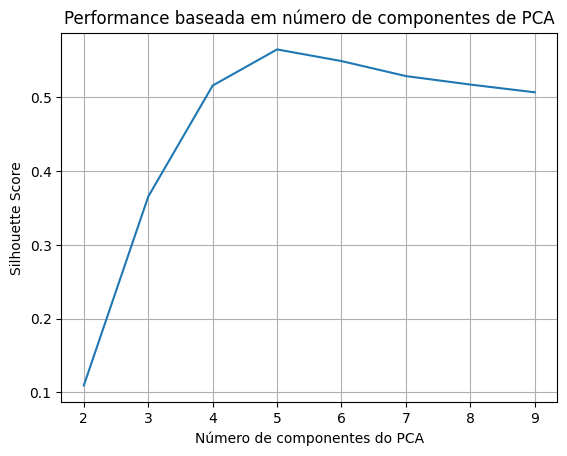

In [58]:
plt.plot(range(2,10), values_list) # Plota o gráfico
plt.xlabel("Número de componentes do PCA")
plt.ylabel("Silhouette Score")
plt.title("Performance baseada em número de componentes de PCA")
plt.grid() # Adiciona uma grade
plt.show()

Neste caso, o melhor valor de `n_components` seria 5\*. Porém, é necessária cautela com este valor, pois com diferentes `random_state` ocorrerem alterações no valor:

\* *Como há aleatoriedade inata no modelo, este valor pode mudar para cada instância de PCA.*

In [59]:
pipe_pca = Pipeline([('standard_scaler', scaler),
              ('pca', PCA(n_components=5, # Use o valor mais alto obtido
                          random_state=456))]) # Estado 456, diferente de 123

pca_value = pipe_pca.fit_transform(df_copia) # Treina e modifica o pca_value
score_novo = silhouette_score(pca_value, labels, metric='cosine') # Calcula o score
print(5, score_novo)

print('A diferença entre ambos foi:', values_list[3] - score_novo)

5 0.5652016849904051
A diferença entre ambos foi: 2.825032097142355e-09


### PCA para visualização

Também é possível usar `PCA` para reduzir o número de dimensões, de forma a possibilitar a visualização dos resultados. Para isso, usa-se `n_components = 2`

In [60]:
pca_visu = PCA(n_components=2, # 2 dimensões, x e y
               random_state=123)

pipe_visu = Pipeline([('standard_scaler', scaler),
                      ('pca', pca_visu),
                      ('kmeans', model)])

pipe_visu.fit(df_copia) # Treina o modelo
dados_visu = pipe_visu[0:2].transform(df_copia) # Transforma os dados com scaler -> pca
pd.DataFrame(dados_visu).head() # Transforma em DataFrame para visualizar

,0,1
0,-57.446987,-95.410981
1,-16.919430,-0.732470
2,-70.345218,19.303327
3,-49.161591,9.227586
4,-18.132534,51.327797


Vamos recalcular os centróides, com uma pipeline que incorpora `PCA`. Eles estão disponíveis atravéis do atributo `.cluster_centers_` de `kmeans`

In [61]:
centroides = pipe_visu['kmeans'].cluster_centers_ # Resgata os centroides
labels_visu = pipe_visu['kmeans'].labels_ # Resgata os rótulos
centroides

array([[-23.93516388,  22.20763104],
       [ 80.8781957 , -33.56782988],
       [-57.10000012, -40.37895218],
       [  7.7909794 ,  56.93533334],
       [ -5.03435244, -14.96379001]])

Assim, podemos fazer um gráfico com estes dados:

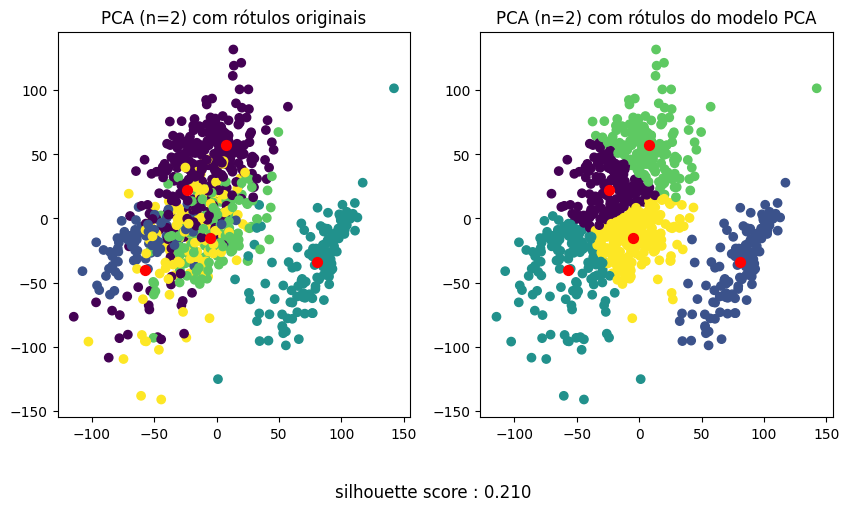

In [62]:
true_label_colors = LabelEncoder().fit_transform(true_labels) # Transforma os
# rótulos originais em números para serem convertidos em cores.

fig, ax = plt.subplots(1,2, figsize=(10,5)) # Cria uma figura com 2 gráficos

# Gráfico com rótulos verdadeiros
ax[0].scatter(dados_visu[:,0], dados_visu[:,1], c=true_label_colors)

# Gráfico com rótulos do nosso modelo de PCA
ax[1].scatter(dados_visu[:,0], dados_visu[:,1], c=labels_visu)


# Adiciona os centróides para ambos gráficos
ax[0].scatter(centroides[:,0], centroides[:,1], c='red', s=50)
ax[1].scatter(centroides[:,0], centroides[:,1], c='red', s=50)


# Adiciona títulos e legenda
ax[0].set_title("PCA (n=2) com rótulos originais")
ax[1].set_title("PCA (n=2) com rótulos do modelo PCA")

# Adicionar um texto com o silhouette score
plt.figtext(0.5, -0.05,
              "silhouette score : %.3f" % silhouette_score(dados_visu, labels) ,
              ha="center", fontsize=12)



plt.show()

Pode-se considerar usar de `PCA` para graficar os centróides do modelo original (treinado sem uso do `PCA`) ou do modelo com `PCA` (`n=0.8`) para visualizar a performance.   
Porém, como o `cluster_centers` vieram de um espaço de maior dimensão, é necessário retreinar o `scaler` e `PCA` com eles na dataframe.  
Ainda sim, é possível usar do PCA com os rótulos do modelo, porém sua informação é menos útil:

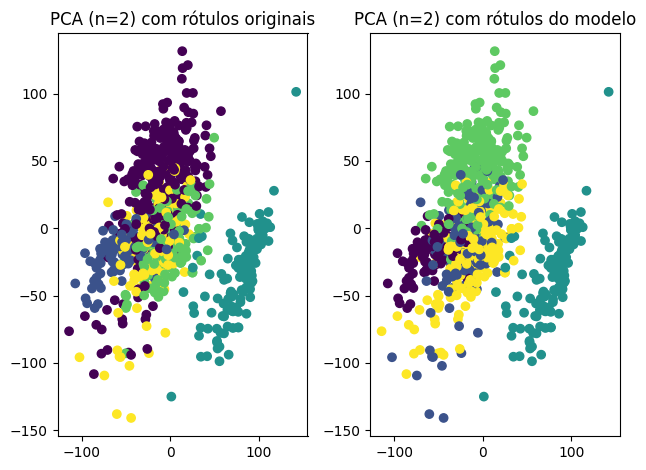

In [63]:
fig, ax = plt.subplots(1,2) # Cria uma figura com 2 gráficos

# Gráfico com rótulos verdadeiros
ax[0].scatter(dados_visu[:,0], dados_visu[:,1], c=true_label_colors)

# Gráfico com rótulos do modelo original
ax[1].scatter(dados_visu[:,0], dados_visu[:,1], c=labels)


# Adiciona título
ax[0].set_title("PCA (n=2) com rótulos originais")
ax[1].set_title("PCA (n=2) com rótulos do modelo")

plt.tight_layout() # Ajusta o layout

plt.show()


## t-SNE
*t-SNE*, ou *t-distributed stochastic neighbor embedding*, é uma forma de redução de dimensões, feita principalmente para visualização.  
Seu uso é semelhante a todos os outros modelos:



In [64]:
from sklearn.manifold import TSNE

Os principais argumentos do `TSNE` são `n_components` - o número de dimensões final; e `perlexity` - relacionado ao número de "vizinhos" para similharidades, e em grandes datasets, é recomendado um número maior.  
Vamos usar de uma pipeline, para ver a performance do *t-SNE* junto a outros modelos.

In [65]:
pipe = Pipeline([('scaler', scaler), # Normaliza os dados
                 ('tsne', TSNE(n_components=2, # 2 Dimensões
                               perplexity=30)) # ~30 perplexidade
                 ])

points = pipe.fit_transform(df_copia) # Aplica a pipeline e salva à variável

points_x = points[:,0] # Seleciona todos valores da primeira coluna da array
points_y = points[:,1] # Seleciona todos valores da segunda coluna da array

Agora, vamos usar de um _scatter plot_ para visualizar os dados. Como também temos os rótulos, podemos ver um pouco da performance.

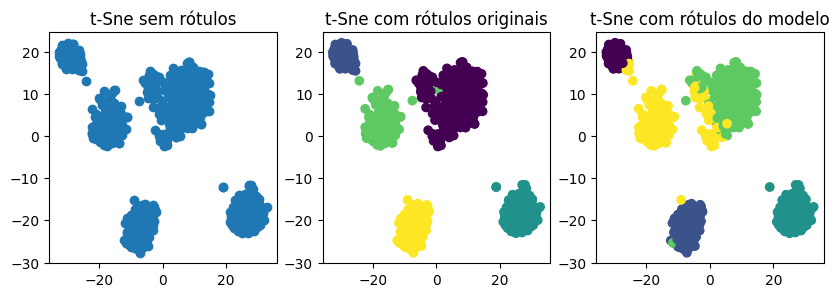

In [66]:
# Declara o modelo, e transforma true_labels em numeros
true_colors = LabelEncoder().fit_transform(true_labels)

# Figura com 3 gráficos
fig, axes = plt.subplots(1, 3, figsize=(10,3))

# Scatterplot dos pontos sem rótulos
axes[0].scatter(x=points_x,
                y=points_y)
axes[0].set_title('t-Sne sem rótulos')

# Scatterplots com core = rótulos originais
axes[1].scatter(c=true_colors,
                x=points_x,
                y=points_y)
axes[1].set_title('t-Sne com rótulos originais')

# Scatterplot com cores = rótulos dados pelo modelo
axes[2].scatter(c=labels,
                x=points_x,
                y=points_y)
axes[2].set_title('t-Sne com rótulos do modelo')

# Mostra a figura
plt.show()

## Escolha de melhor K (Modelagem e Análise)

Neste caso, sabemos que o número de grupos "correto" é 5. Porém, em casos em que não é conhecido, há diferentes maneiras de identificar o número `k` ideal de clusters.

### Método do cotovelo
O método do cotovelo é um método em que se calcula a soma das distâncias dos centróides para cada cluster (`inertia_`), e se escolhe k baseado na redução da inércia. A partir do ponto em que não há uma redução tão significativa, é entendido como o ponto ideal para se parar.

Sua implementação em python pode ser dada por iterações, indo de `k` a `k` em um `for loop`:

In [67]:
lista_scores_inertia = []  # Cria uma lista para incluir os valores

for k in range(2,10): # Para k entre 2 e 10
  model = KMeans(n_clusters=k) # Cria o modelo KMeans com k clusters
  pipe = Pipeline([('scaler', scaler), # Usa de pipeline com scaler e kmeans
                   ('kmeans', model)])

  pipe.fit(df_copia) # Treina o modelo

  lista_scores_inertia.append(pipe['kmeans'].inertia_) # Adiciona o score à lista

Podemos usar de um gráfico para auxiliar na visualização:

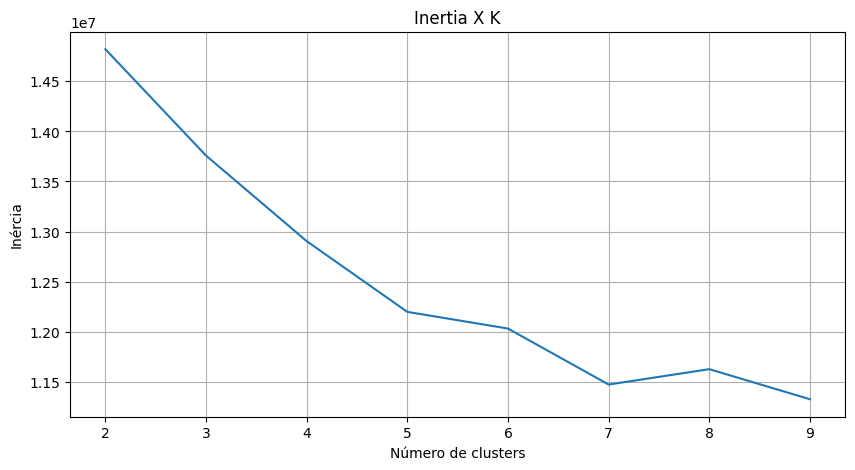

In [68]:
# Ajusta o tamanho da imagem
plt.figure(figsize=(10,5))


# Desenha as linhas
plt.plot(range(2,10), lista_scores_inertia)


# Elementos do gráfico
plt.title('Inertia X K')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.grid()

plt.show()

Percebe-se que há lugares em que a inércia não muda muito de um valor por outro. Tanto que para  `k > 5`, aumentar o número de clusters não diminui significativamente a inércia. Graficamente, o comportamento da linha forma um "cotovelo," da onde vem o nome.

### Por scores
Foram-se vistos bastantes valores de score, e estes também podem ser utilizados para determinar o valor ideal de `k`. Estes também serão feitos de forma iterativa.  
Porém, é necessário estar atento para se um valor melhor indica uma melhor ou pior performance.
Segue o exemplo utilizando `silhouette_score`:

In [69]:
lista_scores_silhouette = []

for k in range(2,10): # Para k entre 2 e 10
  model = KMeans(n_clusters=k,# Cria o modelo KMeans com k clusters
                 random_state=1) # Usa de um random_state para consistência
  pipe = Pipeline([('scaler', scaler),
                   ('kmeans', model)])
  pipe.fit(df_copia) # Treina o modelo
  score = silhouette_score(df_copia, pipe['kmeans'].labels_, metric='cosine') # Calcula o score
  lista_scores_silhouette.append(score) # Adiciona o score à lista

Graficamente:

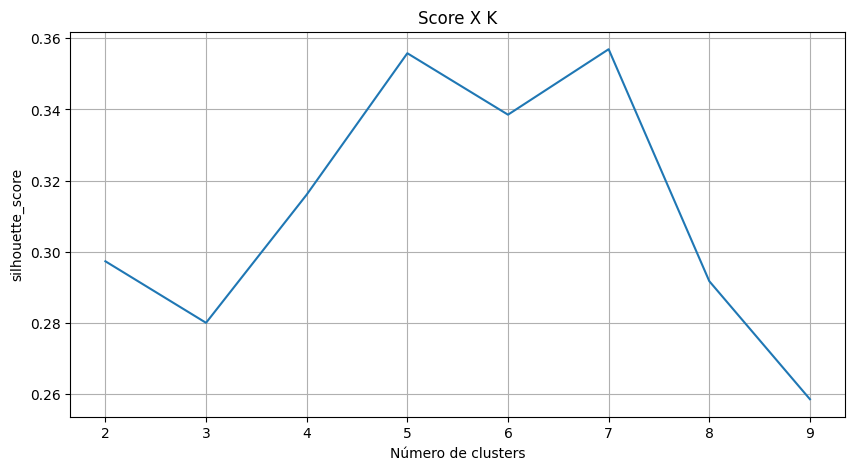

In [70]:
# Ajusta o tamanho da imagem
plt.figure(figsize=(10,5))


# Desenha as linhas
plt.plot(range(2,10), lista_scores_silhouette)


# Elementos do gráfico
plt.title('Score X K')
plt.xlabel('Número de clusters')
plt.ylabel('silhouette_score')
plt.grid()

plt.show()

Novamente, `k=5` é indicado como o melhor valor. De interesse é também `k=7`. Como sabemos que são 5 classes reais, o valor será ignorado; mas em situações reais, ambas quantidades de classes seriam exploradas.

### Biblioteca clusteval
Algumas bibliotecas já automatizam todo o processo de evaluação para encontrar k ideal. Segue abaixo um exemplo - a biblioteca `clusteval`:

Como a biblioteca não se encontra nativamente no ambiente Colab, é necessário instalar ela com `pip`:

In [71]:
try:
    import clusteval
except:
    !pip install clusteval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [clusteval]


Então, importa-se da sua função principal:

In [72]:
from clusteval import clusteval

Então, salva-se esta função a uma variável, e nela se aplica `.fit(dados)` - assim como modelos do `scikit-learn`.

Os principais argumentos são:





- `cluster` : que pode ser "kmeans", "hdbscan", "dbscan", "agglomerative", e define o modelo que será usado para achar os clusters.
- `evaluate` : que será o método usado para achar o k ideal. "derivative" corresponde ao método do cotovelo, e "silhouette" ao `silhouette_score`
- `metric` : a métrica de avaliação que será passado para `silhouette_score`.
Estes argumentos também podem ser omitidos para ser utilizado a configuração padrão:


```
clusteval(cluster = 'agglomerative',
          evaluate = 'silhouette',
          metric = 'euclidean')
```

[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]


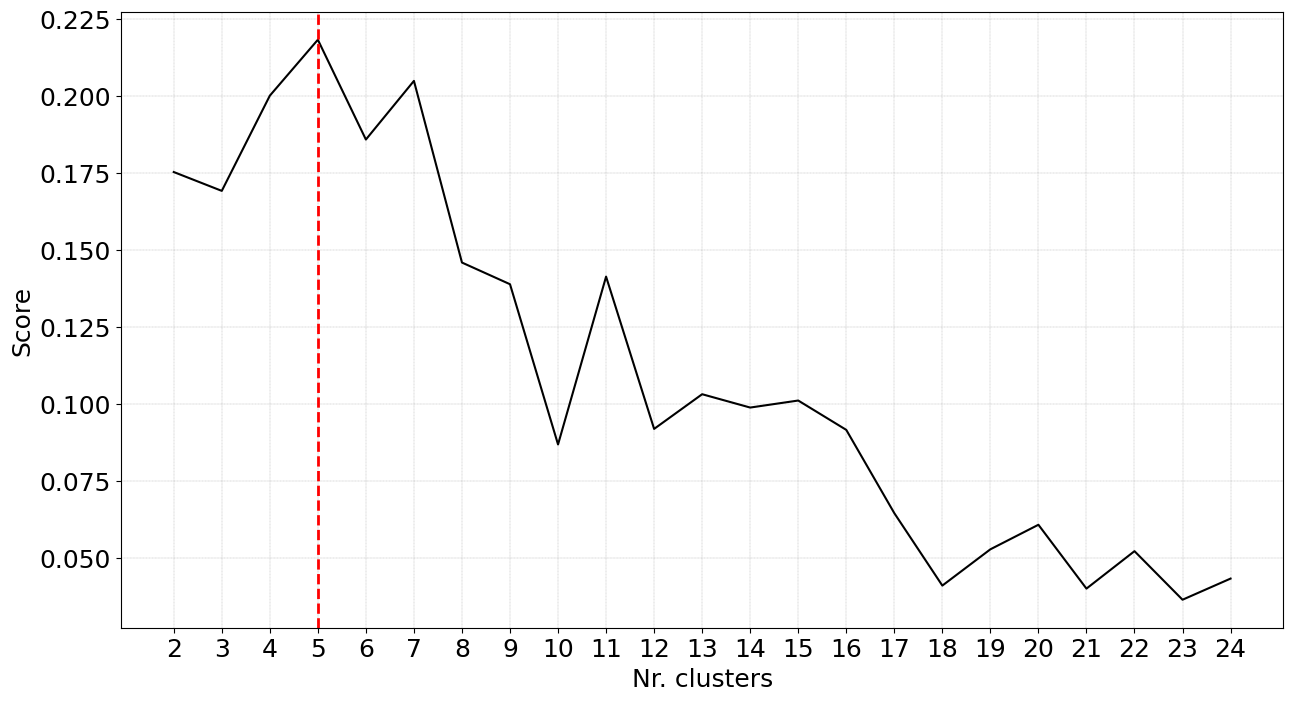

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [73]:
ce = clusteval(cluster = 'kmeans',
               evaluate = 'silhouette',
               metric='cosine')
ce.fit(df_copia)
ce.plot() # Faz o gráfico

O método de escolha de k também são afetados pela dimensionalidade. Então, espera-se diferentes resultados caso as dimensões foram reduzidas. Segue um exemplo com a `df_pca_80_varianca`:

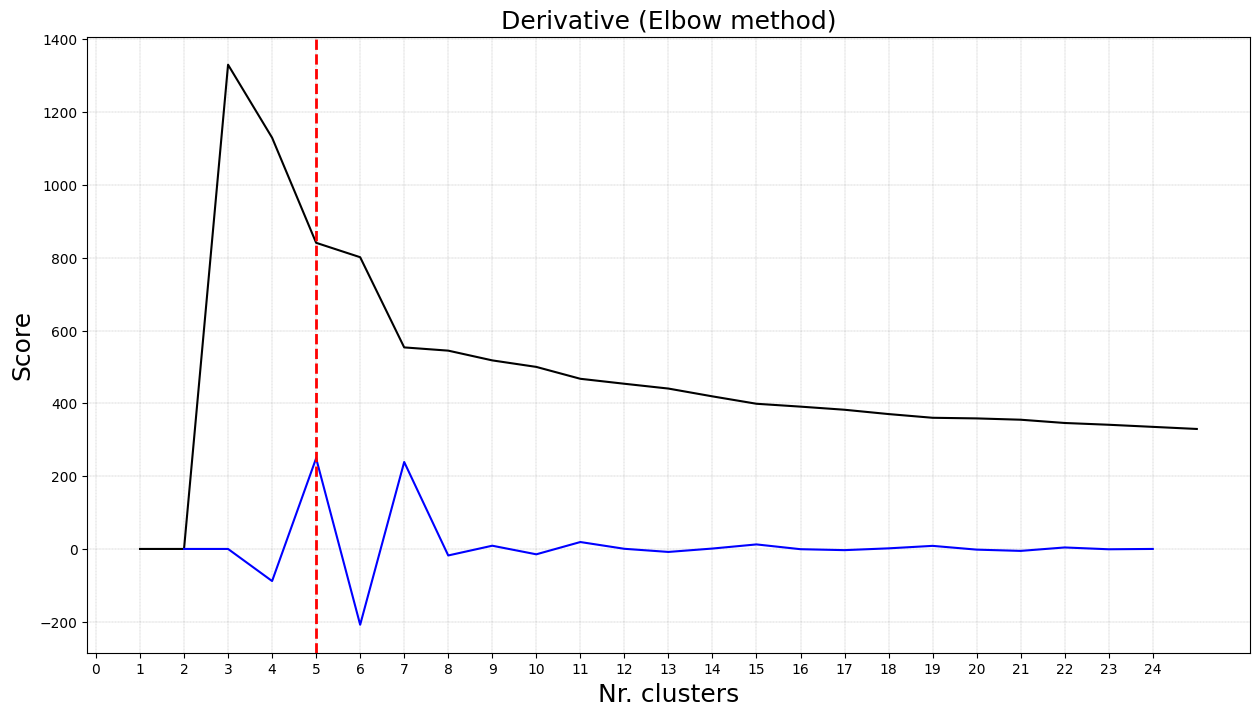

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Derivative (Elbow method)'}, xlabel='Nr. clusters', ylabel='Score'>)

In [75]:
ce = clusteval(evaluate = 'derivative') # Usa do método do cotovelo
ce.fit(df_pca_80_varianca)
ce.plot()

# Exercícios

Crie uma figura com 3 gráficos
- Gráfico reduzido por TSNE, com cores de `true_labels`, e centróides em vermelho.
- PCA com rótulos de um modelo treinado com PCA (`n_componetns=2`) e centróides
- Gráfico com redução por TSNE, com rótulos e centróides de um modelo treinado por PCA

Seguem as variáveis já declaradas:


```
true_colors
scaler
df_copia
```

